Load Reads and reference genome

In [4]:
# Get the kmer table
import sys
sys.path.append('/home/djjoshi')
import all_functions as func
import numpy as np
import Levenshtein as L
%load_ext autoreload
%autoreload 2
kmermap = func.get_kmer_map('/home/djjoshi/r9.4_6mer_nucleotide_template_model.txt')

In [5]:
import sys
print(sys.path)

['/home/djjoshi/nanopore_bioinformatics/read2genome_human/simulations', '/home/djjoshi/anaconda3/lib/python37.zip', '/home/djjoshi/anaconda3/lib/python3.7', '/home/djjoshi/anaconda3/lib/python3.7/lib-dynload', '', '/home/djjoshi/anaconda3/lib/python3.7/site-packages', '/home/djjoshi/anaconda3/lib/python3.7/site-packages/IPython/extensions', '/home/djjoshi/.ipython', '/home/djjoshi']


In [ ]:
# Get Reads
folder = 'expt3/'
sampled_read,sr_nr,sr_name = func.get_reads_from_fasta(folder+'sampled_read.fasta')
print(len(sampled_read))
print(sr_nr)
reads,num_reads,reads_name = func.get_reads_from_fastq(folder+'pass.fastq')
print(len(reads))
print(num_reads)


# reads2,num_reads2,_ = func.get_reads_from_fastq(folder+'ERR2683661.fastq')
# print(len(reads2))
# print(num_reads2)
# print('Done!')

In [ ]:
def get_sampling_ground_truth(filename):
    import numpy as np
    fid = open(filename,'r')
    out = {}
    for aline in fid:
        cols = aline.split('; ')
        read = int(cols[0][5:])
        start = int(cols[1][14:])
        length = int(cols[2][14:-1])
        stop = start+length
        out[read] = np.array([start,stop,length])
    fid.close()
    return out

In [ ]:
sampling_loc = get_sampling_ground_truth(folder+'sampling_location.txt')

In [ ]:
def get_read_number_for_fastq_name(folder):
    out = {}
    from os import listdir
    from os.path import isfile, join
    onlyfiles = [f for f in listdir(folder+'fast5/') if isfile(join(folder+'fast5/', f))]
    print(len(onlyfiles))
    for afile in onlyfiles:
        cols = afile.split('_')
        read = int(cols[2])
        fastq_name = cols[3].split('.')[0]
        out[fastq_name] = read
    return out

In [ ]:
dictionary = get_read_number_for_fastq_name(folder)

In [ ]:
reads_order = []
for i in range(len(reads_name)):
    try:
        num = dictionary[reads_name[i].split(' ')[0][1:]]
        reads_order.append(num)
    except:
        print('Invalid key! {},{}'.format(i,num))
reads_order = np.array(reads_order)
print(reads_order.shape)

In [ ]:
sorted_reads = [None]*num_reads
sorted_reads_name = reads_name
for i in range(len(reads_name)):
    sorted_reads[reads_order[i]-1] = reads[i]
    sorted_reads_name[reads_order[i]-1] = '>read_'+str(reads_order[i])+'\n'
    if i%100 == 0 :
        print('Out_read_length vs True_read_length: {:.4f}'.format(len(reads[i])/len(sampled_read[reads_order[i]-1])))

In [ ]:
func.print_reads_to_fasta(sorted_reads,folder+'reads.fasta',sorted_reads_name)

In [ ]:
# Sanity check ot the above process
sorted_read_length = []
sampled_read_length = []
for i in range(len(sorted_reads)):
    sorted_read_length.append(len(sorted_reads[i]))
sorted_read_length = np.array(sorted_read_length)
for i in range(len(sampled_read)):
    sampled_read_length.append(len(sampled_read[i]))
sampled_read_length = np.array(sampled_read_length)
diff = sorted_read_length/sampled_read_length
print(diff[np.where(diff>1.1)[0]])
print(diff[np.where(diff<0.9)[0]])

In [ ]:
# Sample reads without replacement
idx = np.random.choice(len(reads1),50000,replace=False)
r=[]
r_length = 0
for i in idx:
    r.append(reads1[i])
    r_length+=len(reads1[i])
reads = r
del r,reads1
num_reads = len(reads)
print('num_reads = '+str(num_reads))
print('Average read length = {:.2f}'.format(r_length/num_reads))

In [ ]:
# Get reference genome
ref,num_ref,name = func.get_genome_from_fasta('ref_chr1.fasta')
print(num_ref)
print(len(ref))

In [ ]:
# Get the primary chromosome index
names_index = []
new_names = []
for i in range(len(name)):
    if name[i][:3] == '>NC':
        names_index.append(i)
print(len(names_index))
for i in range(len(names_index)):
    if i<22:
        new_names.append('>ref_chr_'+str(i+1)+'\n')
    elif i==22:
        new_names.append('>ref_chr_X\n')
    elif i==23:
        new_names.append('>ref_chr_Y\n')
    elif i==24:
        new_names.append('>ref_chr_M\n')

In [ ]:
# Get new ref from all ref
new_ref = []
for i in range(len(names_index)):
    new_ref.append(ref[names_index[i]])
print(len(new_ref))

In [ ]:
# Print new ref to fasta
func.print_ref_to_fasta(new_ref,'GRCh38_ref.fasta',new_names)

In [ ]:
# Print Chr_21 to fasta
ref1 = []
ref1 = [new_ref[0]]
func.print_ref_to_fasta(ref1,'ref_chr1.fasta',[new_names[0]])

In [ ]:
print(len(new_ref[0]))

Read the approximate alignments and choose the reads to be used for the experiments

In [ ]:
# Read the paf file
approx_mapping_60,_ = func.extract_from_paf('approx_mapping_60.paf')

In [ ]:
a = np.where(approx_mapping_60[:,7]>10000000)[0]
b = np.where(approx_mapping_60[:,8]<20000000)[0]
c = np.intersect1d(a,b)
print(c.shape)
d = np.unique(approx_mapping_60[c,0])
print(d.shape)

In [ ]:
# Find the read index aligning to the genome section of interest
index = []
for name in name1:
    name = name.split(' ')
    name = name[0]
    name = name.split('.')
    name = int(name[1])
    if name in d:
        index.append(name)
print(len(index))

In [ ]:
reads = []
name = []
for i in index:
    reads.append(reads1[i-1])
    name.append('>read_'+str(i)+'\n')
print(len(reads))
print(len(name))

In [ ]:
# Print the reads to the fasta file
func.print_reads_to_fasta(reads,'reads.fasta')

In [ ]:
approx_mapping_60[55,:]

Converting ACGT reads to Quantized reads

In [ ]:
# Load the read file
reads,num_reads,name = func.get_reads_from_fasta('reads_60.fasta')
print(num_reads)
print(len(reads))

In [ ]:
# Find average read length
read_length = 0
for i in range(num_reads):
    read_length+=len(reads[i])
print('Average read length = {}'.format(read_length//num_reads))

In [ ]:
# Get complement reads
c_reads = [None]*num_reads
for i in range(0,num_reads):
    c_reads[i] = func.complement(reads[i])
print(len(c_reads))

In [ ]:
reads = sorted_reads
num_reads = len(reads)
print(num_reads)
# Get Current reads
import numpy as np
kmer_k = 6
current_reads = [None]*num_reads
rc_current_reads = [None]*num_reads
for i in range(0,num_reads):
    for k in range(0,2):
        seq = reads[i]
        if(k==1):
            seq = func.revcom(seq)
        current_mean = np.zeros(len(seq)-kmer_k+1)
        for j in range(0,len(seq)-kmer_k+1):
            current_mean[j] = kmermap[seq[j:j+6]][0]
        if(k==0):
            current_reads[i] = current_mean
        else:
            rc_current_reads[i] = current_mean
        current_mean = []
    if(i%1000==0):
        print(i)

In [ ]:
# Load the reference file
ref,num_ref,name_ref = func.get_genome_from_fasta('/home/djjoshi/GRCh38_ref.fasta')
print(len(ref))
print(num_ref)
print(name_ref)

In [ ]:
# Get current reference
num_ref = len(ref)
current_ref = [None]*num_ref
kmer_k = 6
for i in range(0,num_ref):
    seq = ref[i]
    current_mean = np.zeros(len(seq)-kmer_k+1)
    for j in range(0,len(seq)-kmer_k+1):
        if 'N' in seq[j:j+6] or 'M' in seq[j:j+6] or 'R' in seq[j:j+6]:
            continue
        try:
            current_mean[j] = kmermap[seq[j:j+6].upper()][0]
        except:
            continue
        if j%100000000 == 0:
            print('{} out of {}'.format(j,len(seq)))
    current_ref[i] = current_mean
    current_mean = []
    print('Completed chromosome {} of {}'.format(i+1,len(ref)))

In [ ]:
# Get quantized levels
folder = '/home/djjoshi/'
Read_qlevels = 1
level = [2,3,4]
if(Read_qlevels==1):
    import pickle
    with open(folder+'qlevels.txt','rb') as f:
        qlevels = pickle.load(f)
    print(qlevels)
else:
    qlevels = [None]*len(level)
    #temp_ref = current_ref[:]
    for i in range(0,len(level)):
        qlevels[i] = func.get_quantize_level(current_ref[0],level[i])
    print(qlevels)
    import pickle
    with open(folder+'qlevels.txt','wb') as f:
        pickle.dump(qlevels,f)

In [ ]:
# Get quantized reads and print it to fasta file
folder = 'expt3/'
for i in range(0,len(level)):
    print('Quantizing to level {}'.format(level[i]))
    reads_q = []
    rc_reads_q = []
    for j in range(0,num_reads):
        reads_q+=[func.get_quantized_seq(current_reads[j],qlevels[i])]
        rc_reads_q+=[func.get_quantized_seq(rc_current_reads[j],qlevels[i])]
        if j%1000 == 0:
            print('Quantizing read {} of {}'.format(j,len(reads)))
    func.print_reads_to_fasta(reads_q,folder+'reads_q'+str(level[i])+'.fasta',reads_name)
    func.print_reads_to_fasta(rc_reads_q,folder+'rc_reads_q'+str(level[i])+'.fasta',reads_name)

In [ ]:
# Get quantized ref and print it to fasta file
for i in range(0,len(level)):
    ref_q=[]
    for j in range(0,num_ref):
        ref_q+=[func.get_quantized_seq(current_ref[j],qlevels[i])]
    func.print_ref_to_fasta(ref_q,'ref_q'+str(level[i])+'.fasta',name_ref)

In [ ]:
# Print reads to fasta files
#func.print_reads_to_fasta(reads,folder+'reads.fasta')
func.print_reads_to_fasta(c_reads,folder+'c_reads.fasta')

In [ ]:
# Save the reads and reference files
import pickle
with open(folder+'reads.txt','wb') as f:
    pickle.dump(reads,f)
#with open(folder+'ref.txt','wb') as f:
#    pickle.dump(ref,f)

# To load the lists use the following:
# with open('reads.txt', 'rb') as f:
#     reads = pickle.load(f)

In [ ]:
# Test new quantization function
import time
%timeit r1 = func.get_quantized_sequences(current_reads[0],qlevels[2])
%timeit r2 = func.get_quantized_seq(current_reads[0],qlevels[2])

In [ ]:
############### Analysis #####################
reads,_,_ = func.get_reads_from_fasta(folder+'reads_q2.fasta')
rc_reads,_,_ = func.get_reads_from_fasta(folder+'rc_reads_q2.fasta')
print(len(reads[541]))
print(len(reads[853]))
print(len(rc_reads[541]))
print(len(rc_reads[853]))

In [ ]:
r = []
rc_r = []
r.append(reads[541])
r.append(reads[853])
rc_r.append(rc_reads[541])
rc_r.append(rc_reads[853])
print(len(r))
print(len(rc_r))

In [ ]:
func.print_reads_to_fasta(r,'test.fasta')
func.print_reads_to_fasta(rc_r,'test_rc.fasta')

In [ ]:
def swap_read_index(reads_name):
    out = {}
    for i in range(len(reads_name)):
        index = int(reads_name[i][6:])
        out[index] = i
    return out

In [ ]:
read_index = swap_read_index(reads_name)

In [ ]:
print(reads_name[1])

In [ ]:
index = 86
print(sampling_loc[index])
print(len(reads[read_index[index]]))

In [ ]:
L.distance(ref[0][sampling_loc[index][0]:sampling_loc[index][1]].upper(),reads[read_index[index]].upper())/sampling_loc[index][2]

In [ ]:
ref[0][sampling_loc[index][0]:sampling_loc[index][1]]

In [3]:
#################### CIGAR Analysis ##########################
folder = 'expt1_a0.05_s2.5/'
from cigar import Cigar

In [8]:
align1,align_ed1,cigar1 = func.extract_from_paf(folder+'align_11.paf',1)

The dimension of the extracted PAF file is: (10125, 16)
Total time taken: 0.36 seconds


In [9]:
align2,align_ed2,cigar2 = func.extract_from_paf('../expt2_MinION/align_11.paf',1)

Unknown mapping type: tp:A:I

Unknown mapping type: tp:A:I

Unknown mapping type: tp:A:I

Unknown mapping type: tp:A:I

Unknown mapping type: tp:A:i

Unknown mapping type: tp:A:i

Unknown mapping type: tp:A:i

Unknown mapping type: tp:A:i

Unknown mapping type: tp:A:i

Unknown mapping type: tp:A:i

Unknown mapping type: tp:A:i

Unknown mapping type: tp:A:I

Unknown mapping type: tp:A:I

Unknown mapping type: tp:A:i

Unknown mapping type: tp:A:i

Unknown mapping type: tp:A:i

Unknown mapping type: tp:A:I

Unknown mapping type: tp:A:i

Unknown mapping type: tp:A:i

Unknown mapping type: tp:A:i

Unknown mapping type: tp:A:i

Unknown mapping type: tp:A:i

Unknown mapping type: tp:A:i

Unknown mapping type: tp:A:i

Unknown mapping type: tp:A:i

Unknown mapping type: tp:A:i

Unknown mapping type: tp:A:i

Unknown mapping type: tp:A:i

Unknown mapping type: tp:A:I

Unknown mapping type: tp:A:i

Unknown mapping type: tp:A:I

Unknown mapping type: tp:A:i

Unknown mapping type: tp:A:i

Unknown ma

In [48]:
start_gap1 = []
end_gap1 = []
match_length1 = []
insertion_length1 = []
deletion_length1 = []
for i in range(1000):
    if align1[i,11] > 55:
        start_gap1.append(align1[i,2])
        end_gap1.append(align1[i,1]-align1[i,3])
        c = Cigar(cigar1[i])
        c = list(c.items())
        for j in range(len(c)):
            if c[j][1] == 'M':
                match_length1.append(c[j][0])
            elif c[j][1] == 'I':
                insertion_length1.append(c[j][0])
            elif c[j][1] == 'D':
                deletion_length1.append(c[j][0])
start_gap1 = np.array(start_gap1)
end_gap1 = np.array(end_gap1)
match_length1 = np.array(match_length1)
insertion_length1 = np.array(insertion_length1)
deletion_length1 = np.array(deletion_length1)

In [14]:
import matplotlib.pyplot as plt

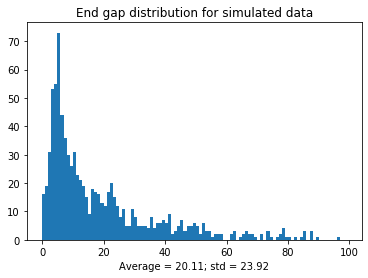

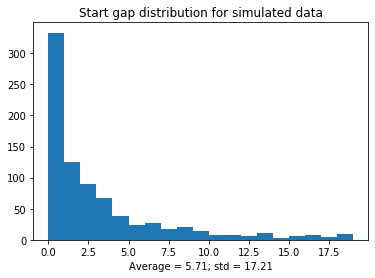

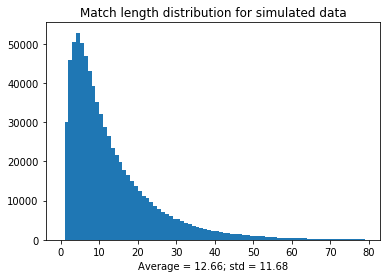

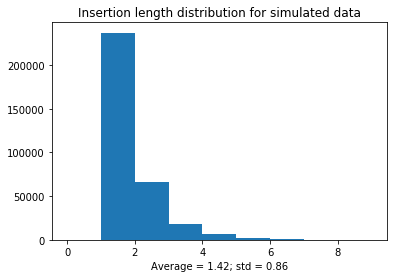

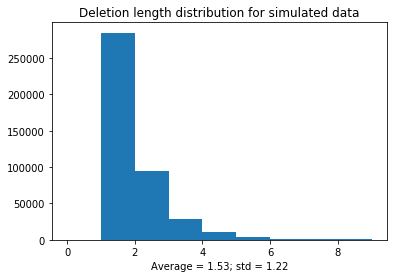

In [50]:
plt.hist(end_gap1,bins=range(100))
plt.title('End gap distribution for simulated data')
plt.xlabel('Average = {:.2f}; std = {:.2f}'.format(sum(end_gap1)/len(end_gap1),np.std(end_gap1)))
plt.show()

plt.hist(start_gap1,bins=range(20))
plt.title('Start gap distribution for simulated data')
plt.xlabel('Average = {:.2f}; std = {:.2f}'.format(sum(start_gap1)/len(start_gap1),np.std(start_gap1)))
plt.show()

plt.hist(match_length1,bins=range(80))
plt.title('Match length distribution for simulated data')
plt.xlabel('Average = {:.2f}; std = {:.2f}'.format(sum(match_length1)/len(match_length1),np.std(match_length1)))
plt.show()

plt.hist(insertion_length1,bins=range(10))
plt.title('Insertion length distribution for simulated data')
plt.xlabel('Average = {:.2f}; std = {:.2f}'.format(sum(insertion_length1)/len(insertion_length1),np.std(insertion_length1)))
plt.show()

plt.hist(deletion_length1,bins=range(10))
plt.title('Deletion length distribution for simulated data')
plt.xlabel('Average = {:.2f}; std = {:.2f}'.format(sum(deletion_length1)/len(deletion_length1),np.std(deletion_length1)))
plt.show()

In [51]:
start_gap2 = []
end_gap2 = []
match_length2 = []
insertion_length2 = []
deletion_length2 = []
for i in range(1000):
    if align2[i,11] > 55:
        start_gap2.append(align2[i,2])
        end_gap2.append(align2[i,1]-align2[i,3])
        c = Cigar(cigar2[i])
        c = list(c.items())
        for j in range(len(c)):
            if c[j][1] == 'M':
                match_length2.append(c[j][0])
            elif c[j][1] == 'I':
                insertion_length2.append(c[j][0])
            elif c[j][1] == 'D':
                deletion_length2.append(c[j][0])
                
start_gap2 = np.array(start_gap2)
end_gap2 = np.array(end_gap2)
match_length2 = np.array(match_length2)
insertion_length2 = np.array(insertion_length2)
deletion_length2 = np.array(deletion_length2)

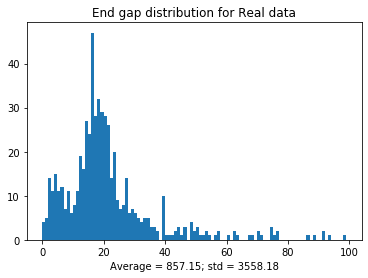

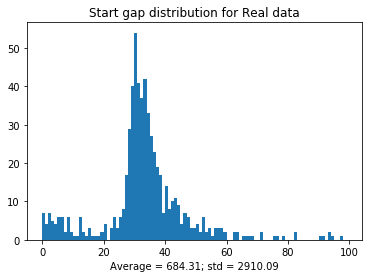

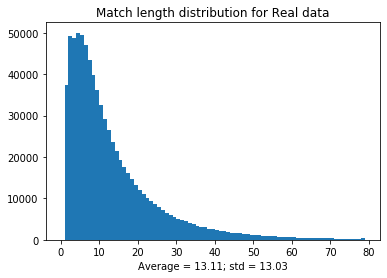

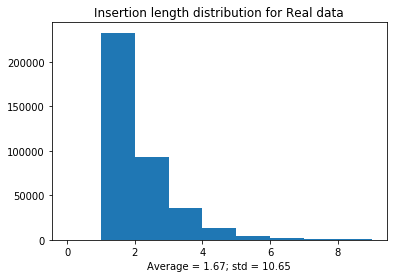

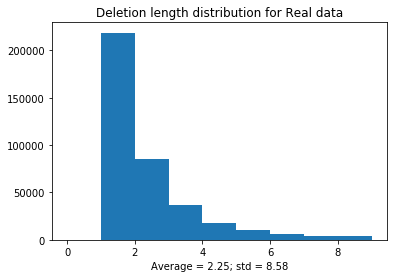

In [52]:
plt.hist(end_gap2,bins=range(100))
plt.title('End gap distribution for Real data')
plt.xlabel('Average = {:.2f}; std = {:.2f}'.format(sum(end_gap2)/len(end_gap2),np.std(end_gap2)))
plt.show()

plt.hist(start_gap2,bins=range(100))
plt.title('Start gap distribution for Real data')
plt.xlabel('Average = {:.2f}; std = {:.2f}'.format(sum(start_gap2)/len(start_gap2),np.std(start_gap2)))
plt.show()

plt.hist(match_length2,bins=range(80))
plt.title('Match length distribution for Real data')
plt.xlabel('Average = {:.2f}; std = {:.2f}'.format(sum(match_length2)/len(match_length2),np.std(match_length2)))
plt.show()

plt.hist(insertion_length2,bins=range(10))
plt.title('Insertion length distribution for Real data')
plt.xlabel('Average = {:.2f}; std = {:.2f}'.format(sum(insertion_length2)/len(insertion_length2),np.std(insertion_length2)))
plt.show()

plt.hist(deletion_length2,bins=range(10))
plt.title('Deletion length distribution for Real data')
plt.xlabel('Average = {:.2f}; std = {:.2f}'.format(sum(deletion_length2)/len(deletion_length2),np.std(deletion_length2)))
plt.show()